1. Dividir em 20 folds

2. Otimizar o parametro com randomsearchCV 3 folds (só do conjunto de treino)

3. Utilizar esses parametros treinar para o conjunto de treino

4. Retornar o AUC no conjunto de teste

## Setup

In [ ]:
# Librarys

## Major libraryies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from scipy import stats
## Progress bar
from tqdm import tqdm
## skleaarn features
### sklearn model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
### sklearn preprocessing
from sklearn.preprocessing import StandardScaler
### sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
### sklearn metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
### xgboost models
from xgboost import XGBClassifier


In [ ]:
dataset = pd.read_csv("sertaozinhoTIDY.csv")
seed = 42

In [ ]:
dataset.shape

(1888, 37)

In [ ]:
#dataset = dataset.dropna()

In [ ]:
dataset.shape

(1888, 37)

In [ ]:
dataset.describe()

,id,month,semester,year,failed_before_2012,pre_k_pub,pre_k_priv,kinder_pub,kinder_priv,act_2012,aes_2012,alt_2012,anx_2012,ass_2012,cmp_2012,dep_2012,ids_2012,ord_2012,sfd_2012,lang_2012,math_2012,delay,delay_years,ethinicity_branca,ethinicity_indigena,ethinicity_parda,ethinicity_preta,gender_mulher,grade_2012_5.0,grade_2012_6.0,mother_educ_ef2,mother_educ_em,mother_educ_nao_sabe,mother_educ_nunca_estudou,mother_educ_superior,school_2012_municipal,school_2012_privada
count,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000
mean,2652.367055,6.279131,1.466631,2000.749470,0.269068,0.448623,0.036017,0.771716,0.078390,0.027004,-0.040475,-0.036482,0.033438,0.057030,0.042545,0.021433,0.001100,-0.008999,0.027015,0.017508,0.017356,0.133475,0.143008,0.403602,0.011123,0.456568,0.112818,0.519068,0.524894,0.446504,0.226165,0.252119,0.010064,0.154661,0.064619,0.639831,0.100106
std,1528.163148,3.414789,0.499017,0.905293,0.443593,0.497485,0.186382,0.419838,0.268855,0.972697,0.993413,0.962960,0.988440,0.973832,1.007410,0.979368,0.976056,0.962067,0.984932,0.981209,0.992427,0.340177,0.500867,0.490749,0.104905,0.498242,0.316454,0.499769,0.499512,0.497262,0.418458,0.434344,0.099838,0.361677,0.245917,0.480177,0.300221
min,5.000000,1.000000,1.000000,1994.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.333034,-3.454074,-2.940817,-3.762595,-3.047933,-2.678637,-2.365950,-3.934303,-2.407924,-3.058979,-3.594707,-3.035328,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1368.500000,3.000000,1.000000,2000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.657450,-0.681952,-0.715586,-0.382502,-0.546322,-0.655119,-0.699856,-0.605261,-0.719280,-0.589534,-0.406369,-0.597954,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2687.500000,6.000000,1.000000,2001.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.076178,-0.080858,-0.075450,0.040009,0.015435,0.034762,-0.134814,0.000954,-0.156399,0.016178,0.161777,0.081594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3959.000000,9.000000,2.000000,2001.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.766651,0.617711,0.556111,0.885032,0.699616,0.756731,0.577631,0.627718,0.576519,0.663631,0.718352,0.722798,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5305.000000,12.000000,2.000000,2003.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.553970,3.233283,3.760280,3.234790,3.357291,2.864741,5.392776,3.203273,4.159023,3.126766,1.725766,2.012405,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
personality_traits = ['act_2012', 'aes_2012', 'alt_2012', 'anx_2012', 'ass_2012', 'cmp_2012', 'dep_2012', 'ids_2012',
       'ord_2012', "sfd_2012"]

In [ ]:
y = dataset.delay
X = dataset.drop(["delay", "delay_years", "id"], axis=1)

In [ ]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

## Main functions

In [ ]:
def model_test(pipe, X_train, X_test, y_train, y_test):
    '''
    Test the model with best params
    '''
    pipe.fit(X_train, y_train)
    predictions = pipe.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, predictions)

In [ ]:
def best_xgb_clas_model(X_train, y_train, params, scoring = 'roc_auc', 
                   sample_weight=None, sample_weight_eval_set=None, 
                   colsample_bynode = 1, n_estimators=500, n_jobs=-1, n_iter=50):
    '''
    Calculates and returns the best xgboost model using randomsearchCV
    '''
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('xgbclas', XGBClassifier(
        random_state=seed,
        objective = "binary:logistic"
        ))
    ])
    optimal_params = RandomizedSearchCV(estimator = pipe, 
                       param_distributions=params, 
                       n_iter = 25, scoring = "roc_auc", 
                       cv = 5, n_jobs = -1,random_state = 42)

    ###
    optimal_params.fit(X_train, y_train)

    ###
    pipe = Pipeline([
    ("scaler", StandardScaler()),                
    ("xgbclas", XGBClassifier(
        # Global parameters
        booster = "gbtree", # Type of booster (tree or linear)
        # Learning Task Parameters
        objective='binary:logistic', # Specify the learning task and the corresponding learning objective
        random_state=seed,
        n_jobs=-1,
        # Parameters for Tree Booster
        gamma = optimal_params.best_params_["xgbclas__gamma"], # Minimum loss reduction required to make a further partition on a leaf node of the tree
        reg_lambda = optimal_params.best_params_['xgbclas__reg_lambda'], # L2 regularization term on weights
  
    ))
    ])

    return pipe

In [ ]:
def test_xgb_model(X_train, X_test, y_train, y_test):
    '''
    Test xgboost model with the best params
    '''
    param_grid = {
    "xgbclas__reg_lambda" : np.linspace(10,50,7),
    "xgbclas__gamma" : np.linspace(1e-1,1,5),
    }
    pipe = best_xgb_clas_model(X_train, y_train, param_grid)
    return model_test(pipe,X_train,X_test,y_train,y_test)



In [ ]:
param_grid = {
    "xgbclas__reg_lambda" : np.linspace(10,50,7),
    "xgbclas__gamma" : np.linspace(1e-1,1,5),
    }
param_grid

{'xgbclas__gamma': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
 'xgbclas__reg_lambda': array([10.        , 16.66666667, 23.33333333, 30.        , 36.66666667,
        43.33333333, 50.        ])}

In [ ]:
def best_model_logreg(X_train, X_test, y_train, y_test, params, seed=seed, scoring = 'roc_auc'):
    '''
    Calculates and returns the best logist regression model using randomsearchCV
    '''
    pipe = Pipeline([('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(penalty="elasticnet", 
                                               solver='saga',
                                               max_iter = 3000,
                                               random_state = seed))]) 
    rcv = RandomizedSearchCV(pipe, params, n_iter = 100, scoring = scoring, cv = 3, n_jobs = -1, random_state = seed)
    rcv.fit(X_train, y_train)
    scaler = StandardScaler()
    X_train_ = scaler.fit_transform(X_train)
    X_test_ = scaler.transform(X_test)
    cls = LogisticRegression(penalty="elasticnet", 
                           solver='saga',
                           max_iter = 3000,
                           random_state = seed,
                           C = rcv.best_params_['logreg__C'],
                           l1_ratio = rcv.best_params_['logreg__l1_ratio'])
    cls.fit(X_train_, y_train)
    predictions = cls.predict_proba(X_test_)[:,1]
    auc_score = roc_auc_score(y_test, predictions)   
    return auc_score

In [ ]:
def test_logreg_model(X_train, X_test, y_train, y_test):
    '''
    Test logistic regression model with the best params
    '''
    parameters = {'logreg__C': np.linspace(0, 30, 1000),
              'logreg__l1_ratio': np.linspace(0,1,100)}
    return best_model_logreg(X_train, X_test, y_train, y_test, parameters)



## Core code

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
auc_scores_xgb = {'Personalities Only' : [],
              'Others Only' : [],
              'All Features' : []}
auc_scores_logreg = {'Personalities Only' : [],
              'Others Only' : [],
              'All Features' : []}

for train_index, test_index in tqdm(skf.split(X,y)):
    ## train test split
    X_all_train = X.loc[train_index,:]
    X_all_test = X.loc[test_index,:]
    y_train = y[train_index]
    y_test = y[test_index]
    ## Group division
    X_personality_train = X_all_train[personality_traits]
    X_personality_test = X_all_test[personality_traits]
    X_other_train = X_all_train.drop(personality_traits, axis = 1)
    X_other_test =  X_all_test.drop(personality_traits, axis = 1)
    ## list construction
    train_sets = [X_personality_train, X_other_train, X_all_train]
    test_sets = [X_personality_test, X_other_test, X_all_test]
    train_set_names = ['Personalities Only', 'Others Only', 'All Features']
    for i in range(3):
        auc_scores_xgb[train_set_names[i]].append(test_xgb_model(train_sets[i], test_sets[i], y_train, y_test))
        auc_scores_logreg[train_set_names[i]].append(test_logreg_model(train_sets[i], test_sets[i], y_train, y_test))

10it [15:40, 94.02s/it]


## Statistics

In [ ]:
logreg = pd.DataFrame(auc_scores_logreg)
xgb = pd.DataFrame(auc_scores_xgb)

### Log Reg

In [ ]:
!pip install pingouin

     |████████████████████████████████| 204kB 5.4MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.11-cp37-none-any.whl size=203325 sha256=7b1845925a9e4884364582246ca7885f2103757dd27e56d0ea5c915b6f695de7
  Stored in directory: /root/.cache/pip/wheels/79/46/ef/e377eb45c86f278f660d31c4a30e3f733063d28c89462f1aea
  Created wheel for littleutils: filename=littleutils-0.2.2-cp37-none-any.whl size=7051 sha256=fe4bc7f6ff80db7ae5c35b49c59322d0adc971d8a9c8addf0e987198fc7253aa
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin littleutils


In [ ]:
from pingouin import qqplot

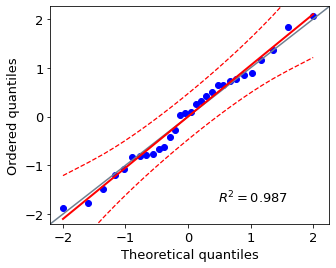

In [ ]:
### Normality of data
qqplot(logreg.melt().value)
plt.title("")
plt.show()

In [ ]:
### Levenne for standart distributions
stats.levene(logreg["All Features"], logreg["Others Only"])

LeveneResult(statistic=0.0155846104947287, pvalue=0.9020351780634416)

In [ ]:
### T-statistic
stats.ttest_ind(logreg["All Features"], logreg["Others Only"])

Ttest_indResult(statistic=0.9229130604239553, pvalue=0.36825906889690907)

## XGBoost Classifier

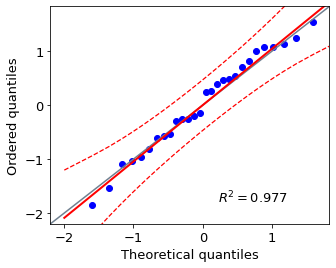

In [ ]:
### Normality of data
qqplot(xgb.melt().value)
plt.title("")
plt.show()

In [ ]:
### Levenne for standart distributions
stats.levene(xgb["All Features"], xgb["Others Only"])

LeveneResult(statistic=0.42861455848634217, pvalue=0.5209482926529669)

In [ ]:
### T-statistic
stats.ttest_ind(xgb["All Features"], xgb["Others Only"])

Ttest_indResult(statistic=1.2579293333693353, pvalue=0.2244918515163733)

### Dipersion Plots

In [ ]:
df = pd.concat([logreg, xgb], axis = 1, keys=['Logistic Regression', 'XGBoost'])

Text(0.5, 1.0, 'XGBoost Classifier')

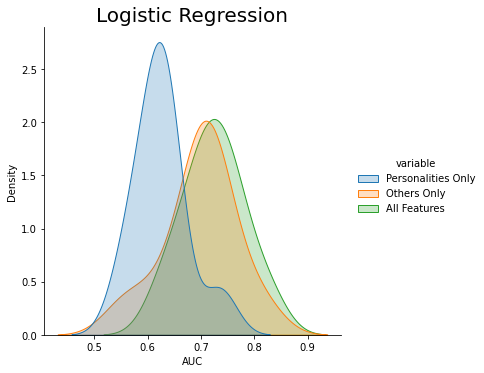

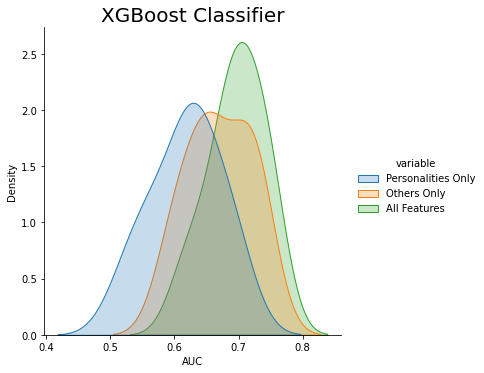

In [ ]:
import numpy as np
df.melt()
sns.displot(data = logreg.melt(value_name="AUC"), x="AUC", hue="variable", kind='kde', fill=True)
plt.title("Logistic Regression", fontsize=20)
sns.displot(data = xgb.melt(value_name="AUC"), x="AUC", hue="variable", kind='kde', fill=True)
plt.title("XGBoost Classifier", fontsize=20)


### Data Frame made

In [ ]:
melted_df = df.melt(value_name="AUC",var_name = ['Classifier', 'Data'])
melted_df.head()

,Classifier,Data,AUC
0,Logistic Regression,Personalities Only,0.627317
1,Logistic Regression,Personalities Only,0.735610
2,Logistic Regression,Personalities Only,0.634878
3,Logistic Regression,Personalities Only,0.623902
4,Logistic Regression,Personalities Only,0.652195


In [ ]:
df.describe()

Logistic Regression              ...     XGBoost             
       Personalities Only Others Only  ... Others Only All Features
count           10.000000   10.000000  ...   10.000000    10.000000
mean             0.624566    0.697349  ...    0.670093     0.696524
std              0.049489    0.067442  ...    0.049732     0.044062
min              0.550731    0.558780  ...    0.598780     0.614390
25%              0.599948    0.684222  ...    0.645274     0.678037
50%              0.625610    0.704878  ...    0.662530     0.698766
75%              0.637615    0.726902  ...    0.717763     0.722256
max              0.735610    0.809325  ...    0.732657     0.754878

[8 rows x 6 columns]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


[0.015649756276150516, 0.01740821850513535]
[0.021327143708796653, 0.015726692802257577]
[0.018192858092705693, 0.013933713865037115]


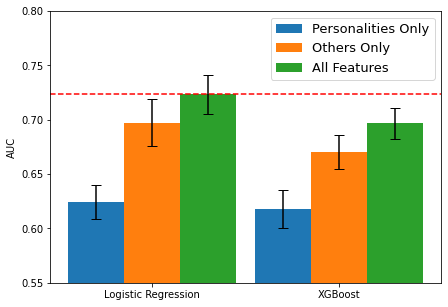

In [ ]:
fig, ax = plt.subplots()
width = 0.3
PO_errors = [np.std(df['Logistic Regression']['Personalities Only'], ddof = 1)/np.sqrt(10),
             np.std(df['XGBoost']['Personalities Only'], ddof = 1)/np.sqrt(10)]

OO_errors = [np.std(df['Logistic Regression']['Others Only'], ddof = 1)/np.sqrt(10),
             np.std(df['XGBoost']['Others Only'], ddof = 1)/np.sqrt(10)]

AF_errors = [np.std(df['Logistic Regression']['All Features'], ddof = 1)/np.sqrt(10),
             np.std(df['XGBoost']['All Features'], ddof = 1)/np.sqrt(10)]

print(PO_errors, OO_errors, AF_errors, sep="\n")
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

fig.set_figheight(5)
fig.set_figwidth(7)

labels = ['Logistic Regression', 'XGBoost']
xx = np.arange(len(labels))
yy1 = [df['Logistic Regression']['Personalities Only'].mean(), df['XGBoost']['Personalities Only'].mean()]
yy2 = [df['Logistic Regression']['Others Only'].mean(), df['XGBoost']['Others Only'].mean()]
yy3 = [df['Logistic Regression']['All Features'].mean(), df['XGBoost']['All Features'].mean()]
plt.rc('font', **font)
#ax.set_title("Bar plot of AUCs simulated")

PO = ax.bar(xx - width,
            yy1, yerr = PO_errors, capsize = 5,
            width = width, label = 'Personalities Only')
OO = ax.bar(xx,
            yy2, yerr = OO_errors, capsize = 5,
            width = width, label = 'Others Only')
AF = ax.bar(xx + width,
            yy3, yerr = AF_errors, capsize = 5,
            width = width, label = 'All Features')

ax.set_ylabel("AUC")
ax.set_xticks(xx)
ax.set_xticklabels(labels)
ax.legend()



#sns.barplot(x = "Classifier", y="AUC", hue="Data", data =  melted_df, ci = None)
ax.set_ylim(0.55,0.8)
ax.axhline(df["Logistic Regression"]["All Features"].mean(), linestyle = 'dashed', color='red')

#fig.tight_layout()

plt.show()

### gain

In [ ]:
ganho_logreg = logreg["All Features"] - logreg["Others Only"]

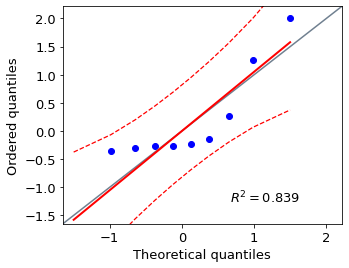

In [ ]:
qqplot(ganho_logreg)
plt.title("")
plt.show()

Text(0.5, 1.0, 'Gain in predictive hability adding personality features')

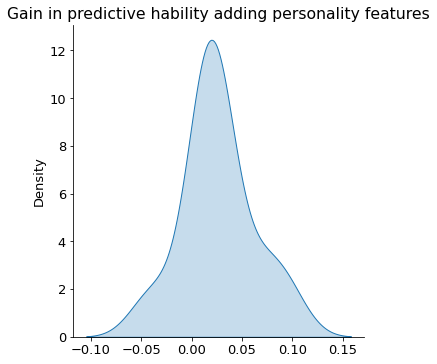

In [ ]:
sns.displot(ganho_logreg, kind='kde',fill=True)

plt.title("Gain in predictive hability adding personality features")

In [ ]:
stats.ttest_1samp(ganho_logreg, 0)

Ttest_1sampResult(statistic=2.350503225610375, pvalue=0.04326939782736384)

In [ ]:
stats.wilcoxon(x=ganho_logreg, zero_method="pratt", alternative = "greater") 

WilcoxonResult(statistic=47.0, pvalue=0.023426642394073573)

In [ ]:
ganho_xgb = xgb["All Features"] - xgb["Others Only"]

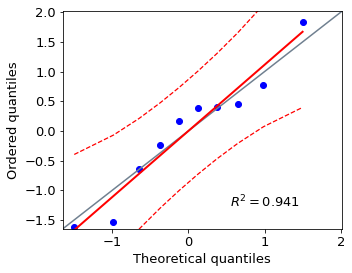

In [ ]:
qqplot(ganho_xgb)
plt.title("")
plt.show()

Text(0.5, 1.0, 'Gain in predictive hability adding personality features')

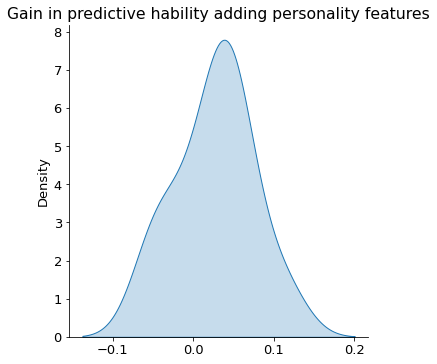

In [ ]:
sns.displot(ganho_xgb, kind='kde',fill=True)
plt.title("Gain in predictive hability adding personality features")

In [ ]:
stats.ttest_1samp(ganho_xgb, 0)

Ttest_1sampResult(statistic=1.7470052557427684, pvalue=0.11458226949459278)

In [ ]:
stats.wilcoxon(x=ganho_xgb, zero_method="pratt", alternative = "greater") 

WilcoxonResult(statistic=43.0, pvalue=0.05706416388111932)

In [ ]:
ganho = pd.concat([ganho_logreg, ganho_xgb], axis = 1, keys=['Logistic Regression', 'XGBoost'])
melted_ganho = ganho.melt(value_name="Gain", var_name = ['Classifier'])


In [ ]:
ganho.head()

,Logistic Regression,XGBoost
0,0.017073,0.061829
1,0.092439,0.110000
2,0.034634,0.044512
3,0.020976,-0.002927
4,0.018293,0.044146


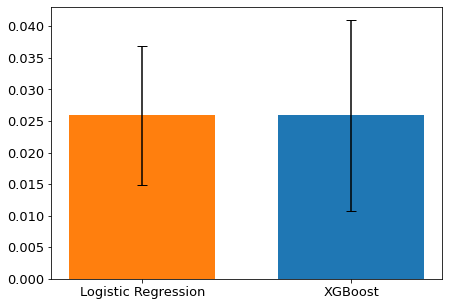

In [ ]:
#sns.barplot(x = "Gain", y="Classifier", data =  melted_ganho, ci = None)
cls_mean = [ganho['Logistic Regression'].mean(), ganho['XGBoost'].mean()]
cls_ep = [np.std(ganho['Logistic Regression'], ddof=1)/np.sqrt(10),
          np.std(ganho['XGBoost'], ddof = 1)/np.sqrt(10)]


plt.figure(figsize=(7,5))
plt.bar(x = ganho.columns, height= cls_mean[0], width = .7 ,yerr = cls_ep, capsize = 5, color = ['tab:orange', 'tab:blue'])


plt.show()

In [ ]:
pd.DataFrame(data = [cls_mean,cls_ep], columns=labels, index=["mean", "std error"])

,Logistic Regression,XGBoost
mean,0.025872,0.026431
std error,0.011007,0.015129
